## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [62]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Загружаем исходные данные

In [66]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [67]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [68]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

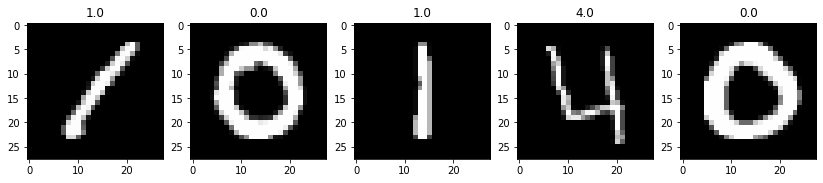

In [69]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [70]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [71]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [72]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [73]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

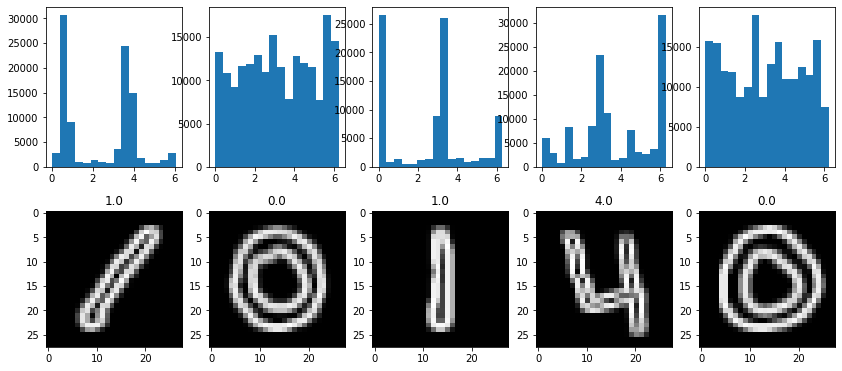

In [74]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [75]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [76]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [77]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [78]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [79]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [16]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [17]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [18]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [22]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

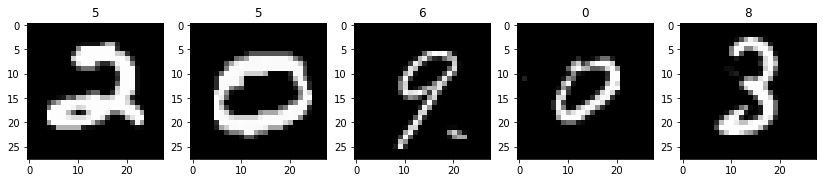

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit_2.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [25]:
!head submit_2.txt

ImageId,Label
1,5
2,5
3,6
4,0
5,8
6,7
7,6
8,3
9,8


In [270]:
# Your submission scored 0.41700

### Далее будем эксперементировать и подбирать лучшие параметры на разных моделях.

In [90]:
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2, random_state=42)

In [91]:
y_train.shape, y_val.shape, x_train.shape, x_val.shape

((33600,), (8400,), (33600, 16), (8400, 16))

#### LogisticRegression

In [92]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.25, 0.5]
}

In [94]:
lr = LogisticRegression(multi_class='ovr', solver='liblinear')
grid_lr = GridSearchCV(lr, lr_params, cv=10, scoring='accuracy')
grid_lr.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.25, 0.5], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [95]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

{'C': 0.5, 'penalty': 'l1'}
0.567827380952381
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


#### RandomForest

In [96]:
forest_params = {
    'n_estimators': [5, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

In [97]:
forest = RandomForestClassifier()
grid_forest = GridSearchCV(forest, forest_params, cv=10, scoring='accuracy')
grid_forest.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [98]:
print(grid_forest.best_params_)
print(grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 40}
0.6368452380952381
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


#### KNN

In [99]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'p': [1, 2]
}

In [100]:
knn = KNeighborsClassifier(n_jobs=-1)
grid_knn = GridSearchCV(knn, knn_params, cv=10, scoring='accuracy')
grid_knn.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [101]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)

{'n_neighbors': 9, 'p': 1}
0.6039880952380953
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                     weights='uniform')


In [102]:
estimators = {
    'LogisticRegression': grid_lr,
    'RandomForest': grid_forest,
    'KNN': grid_knn
}

In [103]:
for key in estimators:
    value = estimators[key]
    print(
    '{0}:\n    {1}{2}\n    {3}{4}\n\n'.format(
        key, 
        "CV Accuracy: ", value.best_score_, 
        "Validation Accuracy: ", value.best_estimator_.score(X_test, y_test)
    )
)

LogisticRegression:
    CV Accuracy: 0.567827380952381
    Validation Accuracy: 0.09857142857142857


RandomForest:
    CV Accuracy: 0.6368452380952381
    Validation Accuracy: 0.10650793650793651


KNN:
    CV Accuracy: 0.6039880952380953
    Validation Accuracy: 0.11674603174603175




### В качестве модели для дальнейшей работы будет KNN т.к. дала более хороший Validation Accuracy на ненормализованных данных и показала более быстрый рассчет по сравнению с RandomForest

#### Нормализация данных с помощью метода главных компонент PCA

In [104]:
from sklearn.decomposition import PCA

In [105]:
pca = PCA(n_components=50)

full_img = np.vstack([train_img.reshape(-1, 28 * 28), test_img.reshape(-1, 28 * 28)])
full_img_pca = pca.fit_transform(full_img)

train_img_pca = full_img[:train_img.shape[0], :]
test_img_pca = full_img[train_img.shape[0]:, :]

In [106]:
y_train2, y_val2, x_train2, x_val2 = train_test_split(train_label, train_img_pca, test_size=0.2, random_state=42)

In [119]:
y_train2.shape, y_val2.shape, x_train2.shape, x_val2.shape

((33600,), (8400,), (33600, 784), (8400, 784))

In [116]:
# kNN = KNeighborsClassifier(n_neighbors=9, n_jobs=-1) # 0.961
# kNN = KNeighborsClassifier(n_neighbors=3, p=1, n_jobs=-1) # 0.960

kNN = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

kNN.fit(x_train2, y_train2)
kNN_pred = kNN.predict(x_val2)

print('Accuracy kNN: {}'.format(accuracy_score(y_val2, kNN_pred)))

Accuracy kNN: 0.9666666666666667


In [117]:
print(classification_report(y_val2, kNN_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       816
         1.0       0.95      1.00      0.97       909
         2.0       0.98      0.95      0.96       846
         3.0       0.97      0.96      0.96       937
         4.0       0.98      0.97      0.98       839
         5.0       0.95      0.97      0.96       702
         6.0       0.97      0.99      0.98       785
         7.0       0.96      0.97      0.96       893
         8.0       0.98      0.93      0.95       835
         9.0       0.95      0.95      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [118]:
print(confusion_matrix(y_val2, kNN_pred))

[[812   0   0   0   0   1   3   0   0   0]
 [  0 907   0   0   0   0   2   0   0   0]
 [  7  13 800   4   3   2   1  14   1   1]
 [  1   5   5 896   0   9   0   8   9   4]
 [  1   3   0   0 816   0   3   1   0  15]
 [  0   0   0   7   1 678   8   0   3   5]
 [  6   0   0   0   0   3 776   0   0   0]
 [  0  14   4   0   1   0   0 863   0  11]
 [  3  11   6  11   2  16   3   2 774   7]
 [  2   2   2   9   9   2   0  14   0 798]]


In [127]:
pred_test = kNN.predict(test_img_pca)

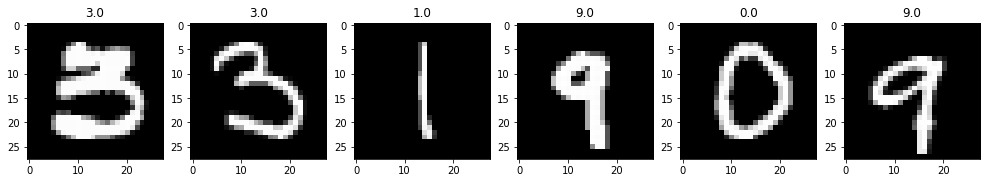

In [165]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(test_img[15:21], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[15 + i - 1]);

In [167]:
def submit(pred, file_name='submit.txt'):
    with open(file_name, 'w') as dst:
        dst.write('ImageId,Label\n')
        for i, p in enumerate(pred, 1):
            dst.write('%s,%s\n' % (i, p))

In [168]:
submit(pred_test.astype(np.int32))

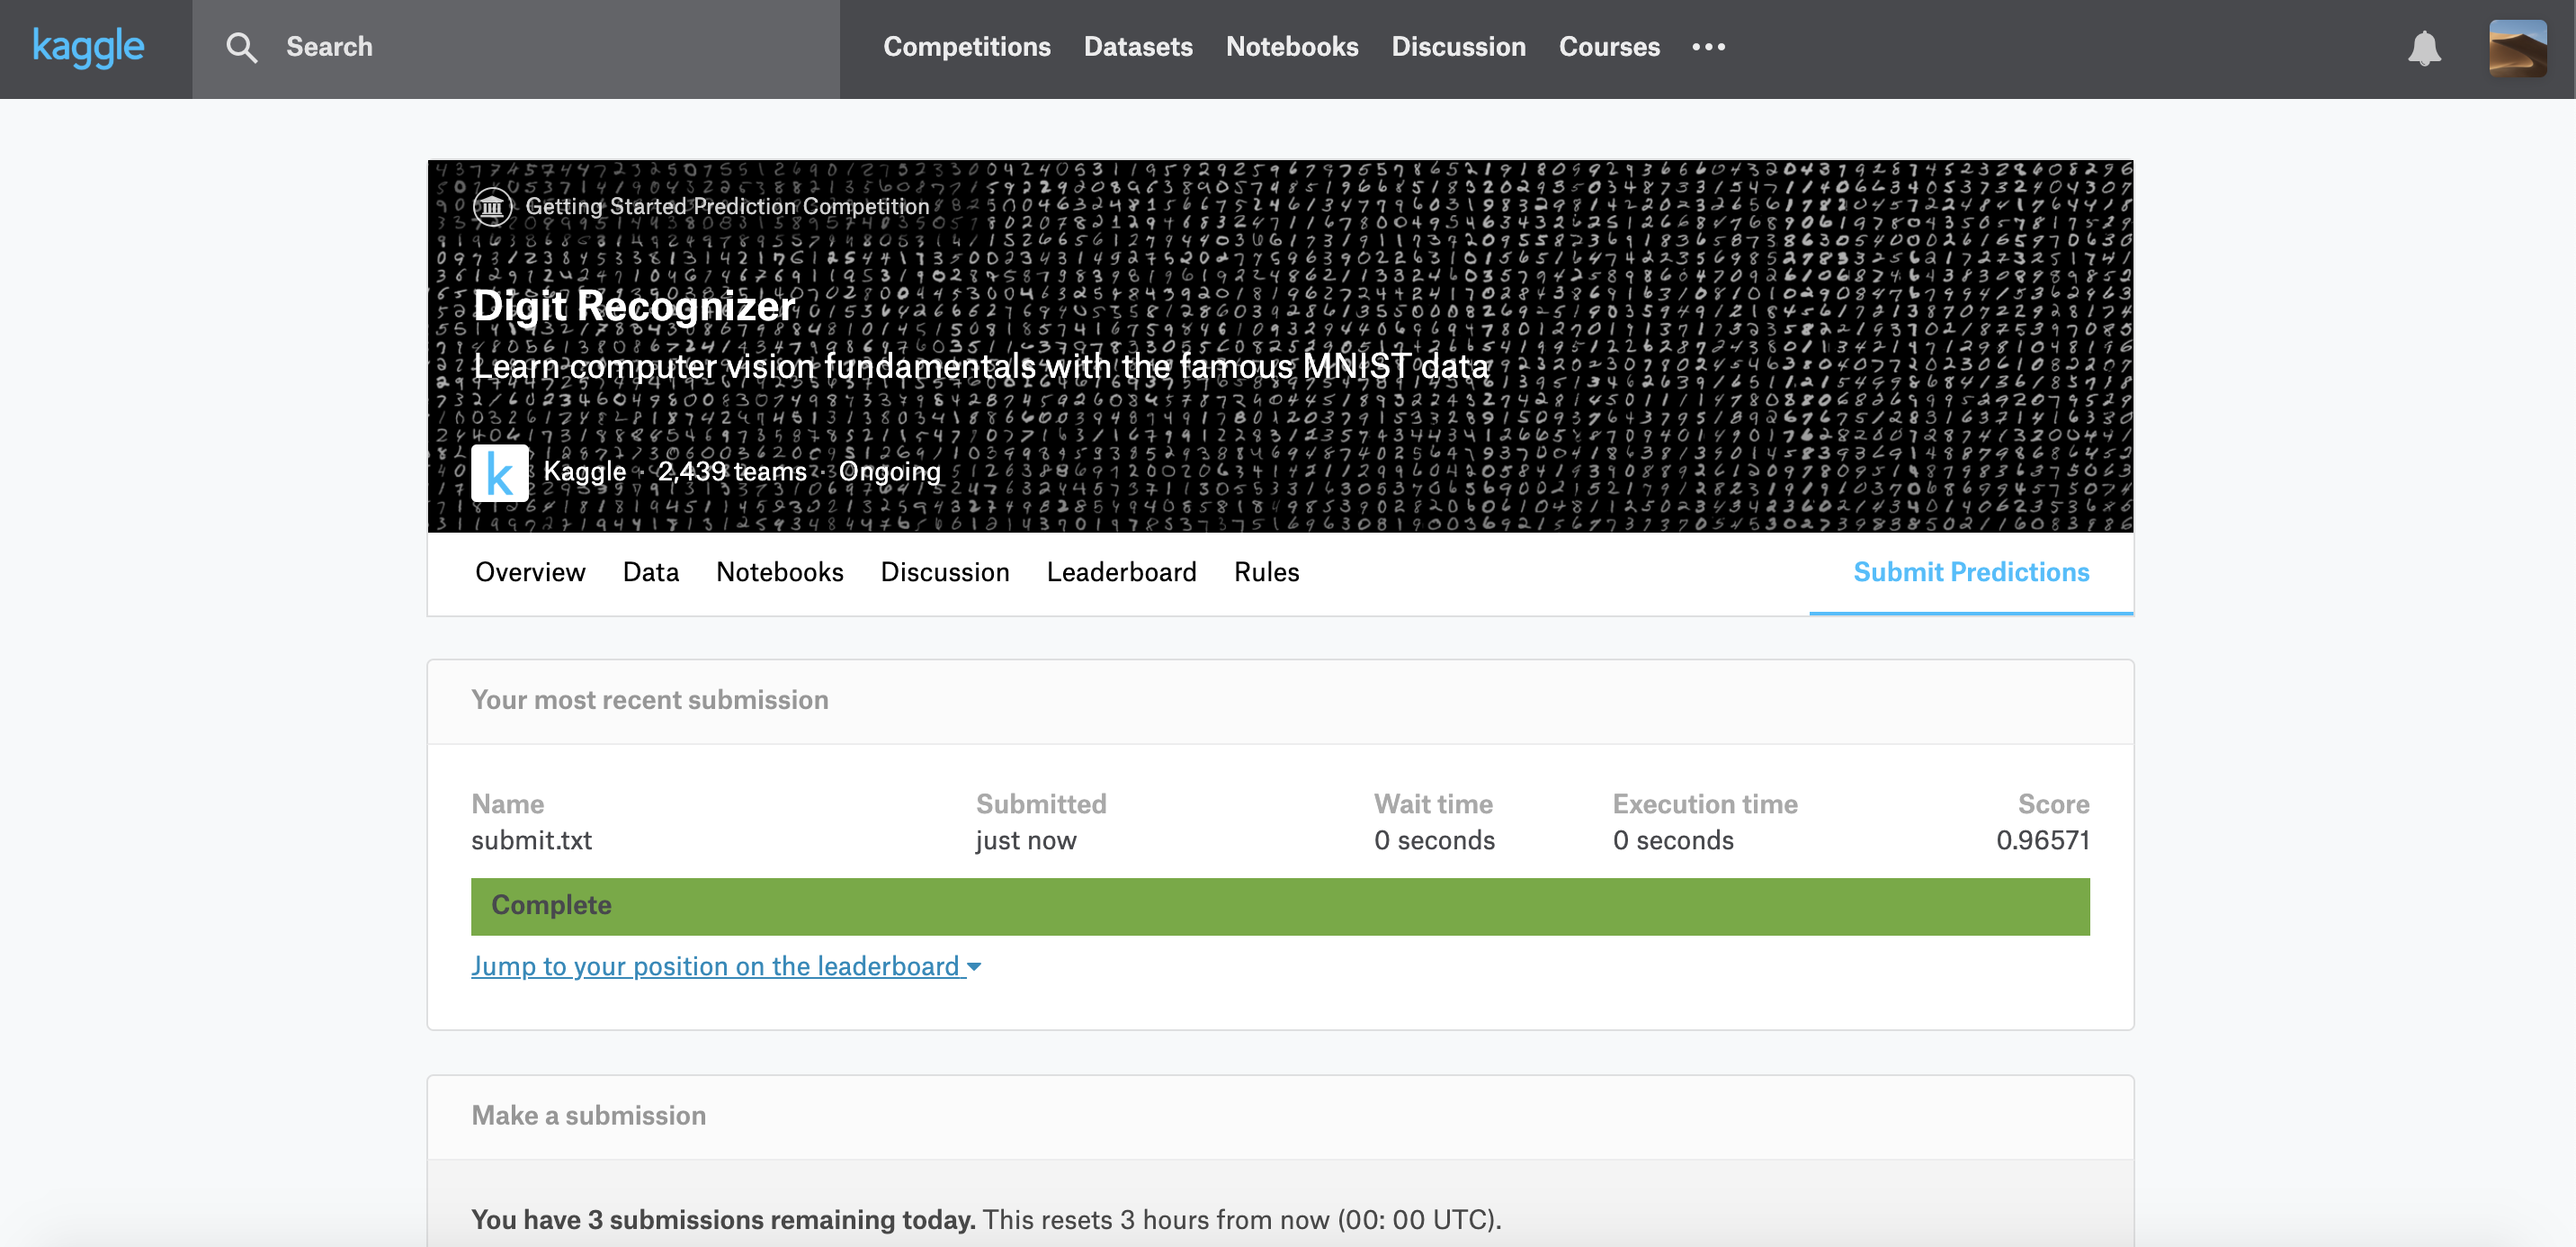

In [169]:
Image("Screenshot 2019-11-13 at 23.45.45.png")

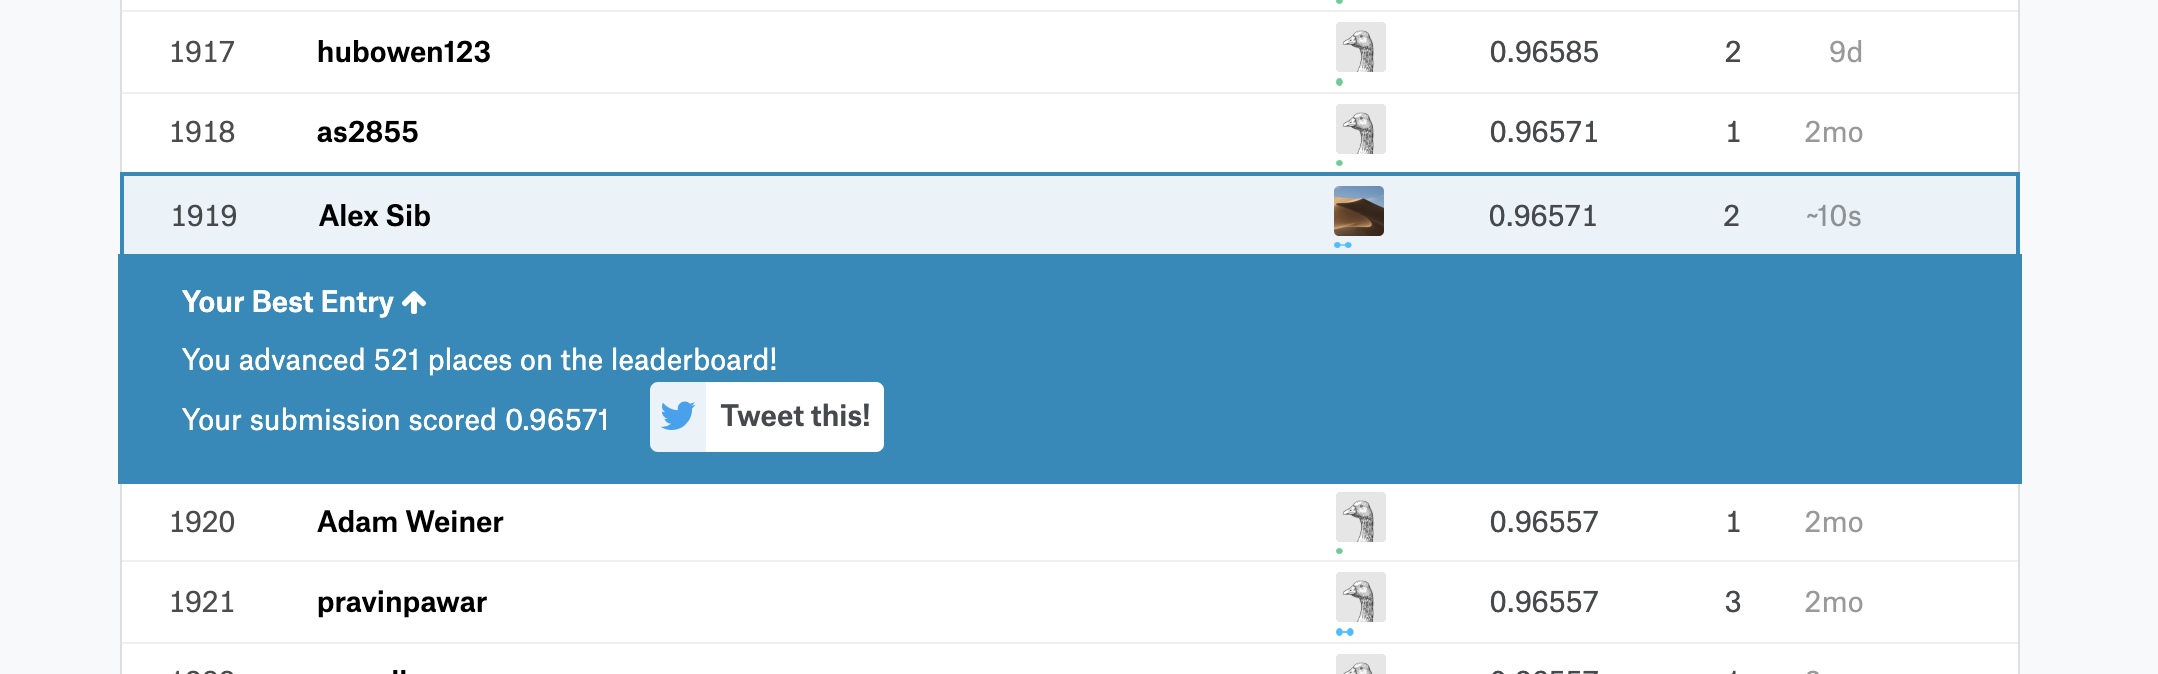

In [170]:
Image("Screenshot 2019-11-13 at 23.46.20.png")

In [ ]:
pass